# Load Required Libraries

In [30]:
import os
import timeit
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
%matplotlib inline 

In [59]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Load Data Files

All data files and meta data were downloaded from __[The Aging Brain Map website](http://aging.brain-map.org/download/index)__ on March 31, 2018.

In [202]:
# %%timeit -n 1 -r 1 -p 2 # uncomment to monitor how long data import takes (you might want to load data in chunks)
# change the working directory - specify the *absolute* file path to the data directory 
os.chdir("/Users/daniel/Documents/Yale/Projects/computations/Allen_aging_brain_map/")

# import all data documents as pandas data frames; rna-seq data are stored in a separate folder
donor_info = pd.read_csv("1_DonorInformation.csv")
stain_description = pd.read_csv("3_DescriptionOfStains.csv")
histology_quantification = pd.read_csv("2_ProteinAndPathologyQuantifications.csv")
group_weights = pd.read_csv("5_group_weights.csv") # I do not know what these weights mean!
rna_specimen_overview = pd.read_csv("4_gene_expression_matrix_2016-03-03/columns-samples.csv")
rna_genes_overview = pd.read_csv("4_gene_expression_matrix_2016-03-03/rows-genes.csv")
rna_seq_data = pd.read_csv("4_gene_expression_matrix_2016-03-03/fpkm_table_normalized.csv")

# Exploratory Data Analysis

## Available Data Files - Overview

Seven different data files contain RNA-sequencing (RNA-seq), histology and clinical patient information. See the following short description of the available data:

1. `donor_info` contains clinical information like dementia (yes/no) and patient age

2. `stain_description` contains a brief description of the available histological data

3. `histology_quantification` contains immunohistochemistry (IHC) and protein quantification data of 377 samples of 107 patients (related to `stain_description`)

4. `group_weights` I have **NO** idea what these 'weights' are derived from

5. RNA-seq data:

    1. `rna_specimen_overview` contains a description of RNA-seq specimens
    
    2. `rna_genes_overview`contains a description of genes that were sequenced
    
    3. `rna_seq_data` contains the *corrected* (for batch effects) *FPKM* values of 377 samples of 107 patients (as described in `rna_specimen_overview`) and 50281 loci (as described in `rna_genes_overview`)

***
Data File | Number of Rows | Number of Columns
--------- | -------------- | -----------------
`donor_info`| 107 | 19
`stain_description`| 62 | 9
`histology_quantification` | 377 | 33
`group_weights` | 107 | 2
`rna_specimen_overview` | 377 | 12
`rna_genes_overview`| 50281 | 5
`rna_seq_data`| 50281 | 377
***

## Join Patient Info Files (`histology_quantification` and `donor_info`)

In [203]:
# set index to 'donor_id'
histology_quantification.index = histology_quantification["donor_id"]
histology_quantification_tmp = histology_quantification.drop("donor_id", axis=1)
donor_info.index = donor_info["donor_id"]
donor_info_tmp = donor_info.drop("donor_id", axis=1)

# join data frames according to index
donor_info_histo_quant = donor_info_tmp.join(other=histology_quantification_tmp)

## Join RNA-seq FPKM Table (`rna_seq_data`) with *hgnc* Gene Names (`rna_genes_overview`) and Patient Infos (`rna_specimen_overview`)

In [204]:
# set indices to 'gene_id' columns (pd.DataFrame.join works best on indices)
rna_genes_overview.index = rna_genes_overview["gene_id"]
rna_seq_data.index = rna_seq_data["gene_id \ rnaseq_profile_id"]

# join data frames according to index
rna_seq_data = rna_seq_data.join(other=rna_genes_overview)
rna_seq_data = rna_seq_data.drop("gene_id \ rnaseq_profile_id", axis=1) # drop duplicate column

In [205]:
# set row indices to rnaseq_profile_id
rna_specimen_overview.index = rna_specimen_overview["rnaseq_profile_id"]
rna_specimen_overview_tmp = rna_specimen_overview.drop("rnaseq_profile_id", axis=1)

# replace indices with gene symbols
rna_seq_data.index = rna_seq_data.loc[:,"gene_symbol"]

In [206]:
# transpose data frame and change index to correct data type
rna_seq_data_trans = rna_seq_data.transpose()
rna_seq_data_trans = rna_seq_data_trans.drop(rna_seq_data_trans.index[-5:])
rna_seq_data_trans.index = rna_seq_data_trans.index.map(int) 

# join
rna_seq_joined = rna_seq_data_trans.join(other=rna_specimen_overview_tmp)

## Join `rna_seq_joined` and `donor_info_histo_quant` to one big data table `all_data_joined`

In [207]:
_unique_id1 = np.add(donor_info_histo_quant.index.values.astype(str), donor_info_histo_quant.structure_acronym.values)
donor_info_histo_quant.index = _unique_id1

_unique_id2 = np.add(rna_seq_joined.donor_id.values.astype(str), rna_seq_joined.structure_acronym.values)
rna_seq_joined.index = _unique_id2

In [213]:
all_data_joined = pd.merge(rna_seq_joined, donor_info_histo_quant, right_index=True, left_index=True)

## RNA Seq Data - Exploratory visualizations

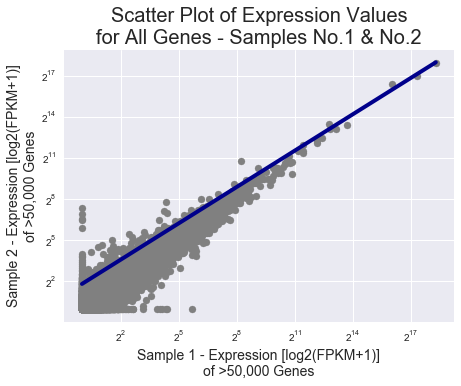

In [38]:
# plot 'log2(FPKM+1)' of patients no. 1 and no. 2 across >50,000 genes
plt.figure(figsize=(7, 5))
plt.xscale("log", basex=2)
plt.yscale("log", basey=2)
plt.grid(True)
plt.xlabel("Sample 1 - Expression [log2(FPKM+1)]\nof >50,000 Genes", fontsize=14)
plt.ylabel("Sample 2 - Expression [log2(FPKM+1)]\nof >50,000 Genes",  fontsize=14)
plt.title("Scatter Plot of Expression Values\nfor All Genes - Samples No.1 & No.2", fontsize=20)
plt.scatter((rna_seq_data.iloc[:, 1]+1), (rna_seq_data.iloc[:, 2]+1), color="gray");

# add a regression line to the graph ('best fit' by minimizing the squared error)
m, b = np.polyfit((rna_seq_data.iloc[:, 1]+1), (rna_seq_data.iloc[:, 2]+1), deg=1)
x_values = np.linspace((rna_seq_data.iloc[:, 1]+1).min(), (rna_seq_data.iloc[:, 1]+1).max(), num=2)
y_values = x_values * m + b
plt.plot(x_values, y_values, "-", color="darkblue", linewidth=4);

Gene expression of patients No.1 and No.2 seem to correlate extremely well. A correlation plot is used to visualize the above relationship across all patients / sample types (i.e. different brain regions):

In [39]:
# create correlation matrix from data frame
corr_matrix = np.log2(rna_seq_data.iloc[:, 0:377]+1).corr()
corr_matrix.columns = list(np.arange(1, 378, 1))
corr_matrix.index = list(np.arange(1, 378, 1))

In [40]:
# create a second correlation matrix and row labels for correlation plot
corr_matrix2 = np.log2((rna_seq_joined.iloc[:, 0:50281]+1).astype(float)).transpose().corr()

In [41]:
# create row colors
sns.set(color_codes=True)
_ = rna_seq_joined.copy()
structure = _.pop("structure_name")

col = dict(zip(structure.unique(), ["darkred", "darkgreen", "darkblue", "gold"]))
row_colors = structure.map(col)

temporal neocortex : darkred
white matter of forebrain : darkgreen
hippocampus (hippocampal formation) : darkblue
parietal neocortex : gold


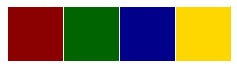

In [42]:
# plot the dictionary that decodes brain regions
sns.palplot(list(col.values()))

_a, _b = list(col.keys()), list(col.values())
for i in range(4):
    print("{a} : {b}".format(a=_a[i], b=_b[i]))

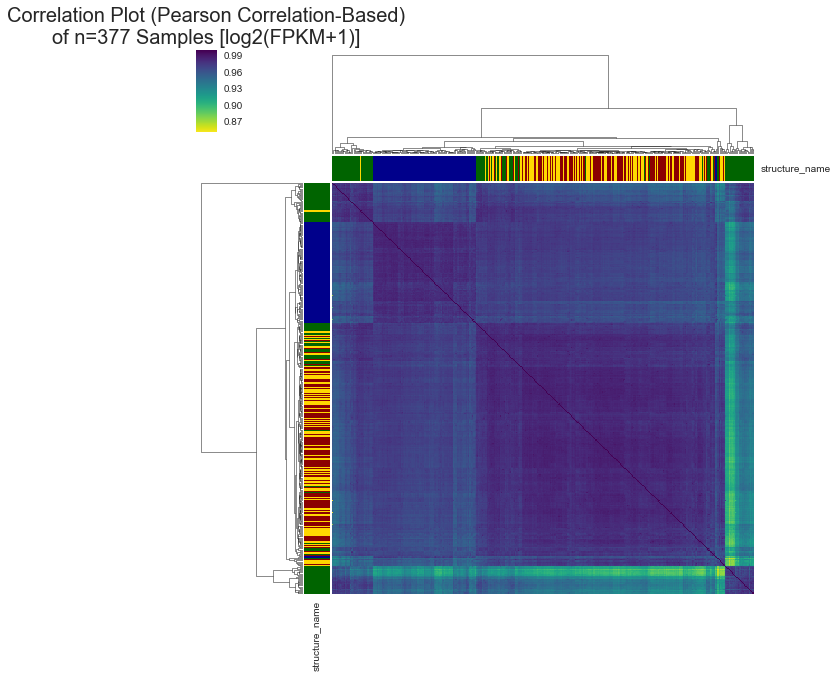

In [43]:
# plot correlation matrix as a heatmap
sns.clustermap(corr_matrix2, vmax=1, vmin=0.85, cmap="viridis_r", yticklabels=False, xticklabels=False,
              row_colors=row_colors, col_colors=row_colors); 
plt.title("Correlation Plot (Pearson Correlation-Based)\nof n=377 Samples [log2(FPKM+1)]", fontsize=20);

The overall correlation between all 377 samples regarding the 50,281 sequenced loci is very high (even better for not-log2 transformed data...). That means that most genes are relatively stably expressed in different brain regions and patients. Some genes do have high variance across samples, though (see 2 sections below). After color-coding brain regions, a certain pattern is visible!

Next, the relationship between **NCS1** and **LIMK1** is visualized:

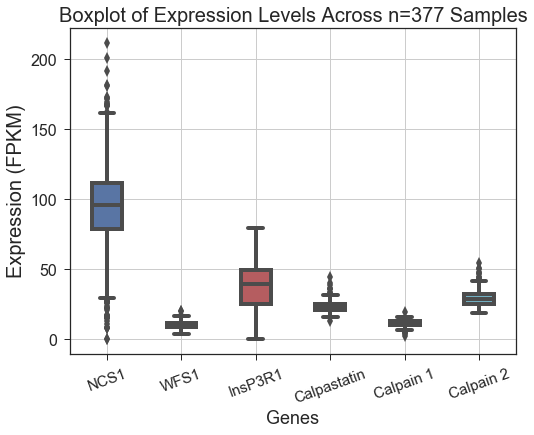

In [44]:
# what is the variance of NCS1 and other genes of interest across all 377 samples?
# plot pd.DataFrame with seaborn
plt.figure(figsize=(8, 6))
sns.set_style("ticks")
boxplt = sns.boxplot(data=rna_seq_joined[["NCS1", "WFS1", "ITPR1", "CAST", "CAPN1", "CAPN2"]], 
                     width=0.4, fliersize=8, linewidth=4);
plt.grid(b=True, which="major")
plt.xticks(list(range(6)), ["NCS1", "WFS1", "InsP3R1", "Calpastatin", "Calpain 1", "Calpain 2"], fontsize=15,
          rotation=20)
plt.yticks(fontsize=16)
plt.xlabel("Genes", fontsize=18);
plt.ylabel("Expression (FPKM)", fontsize=20);
plt.title("Boxplot of Expression Levels Across n=377 Samples", fontsize=20);

# create legend for NCS1 - LIMK1
#cols = sns.xkcd_palette(["windows blue", "amber"])
#NCS1_patch = mpatches.Patch(facecolor=cols[0], edgecolor="black", linewidth=3)
#LIMK1_patch = mpatches.Patch(facecolor=cols[1], edgecolor="black", linewidth=3)
#plt.legend([NCS1_patch, LIMK1_patch], ["NCS1", "LIMK1"], fontsize=20);

In [45]:
# calculate variance across all genes
tmp = rna_seq_data.iloc[:, 0:377]
variance_list = [np.var(tmp.iloc[i, :]) for i in range(tmp.shape[0])]
NCS1_var = np.var(rna_seq_joined[["NCS1"]], axis=0)
LIMK1_var = np.var(rna_seq_joined[["LIMK1"]], axis=0)

## prepare plotting
# color-code variance values in relationship to NCS1
colors = ["darkred" if val < NCS1_var.iloc[0] else "darkblue" for val in variance_list]

# add names for NCS1 and genes with higher variance
names = []
for i in range(len(variance_list)):
    if variance_list[i] >= NCS1_var.iloc[0]:
        names.append(rna_seq_data.iloc[i, -2])
    else:
        names.append("")

larger_than_NCS1 = [name for name in names if name != ""] # create a list of genes with variance >= NCS1        
        
# create xy coordinates for these names               
xy = list(zip(range(1, tmp.shape[0]+1), variance_list))

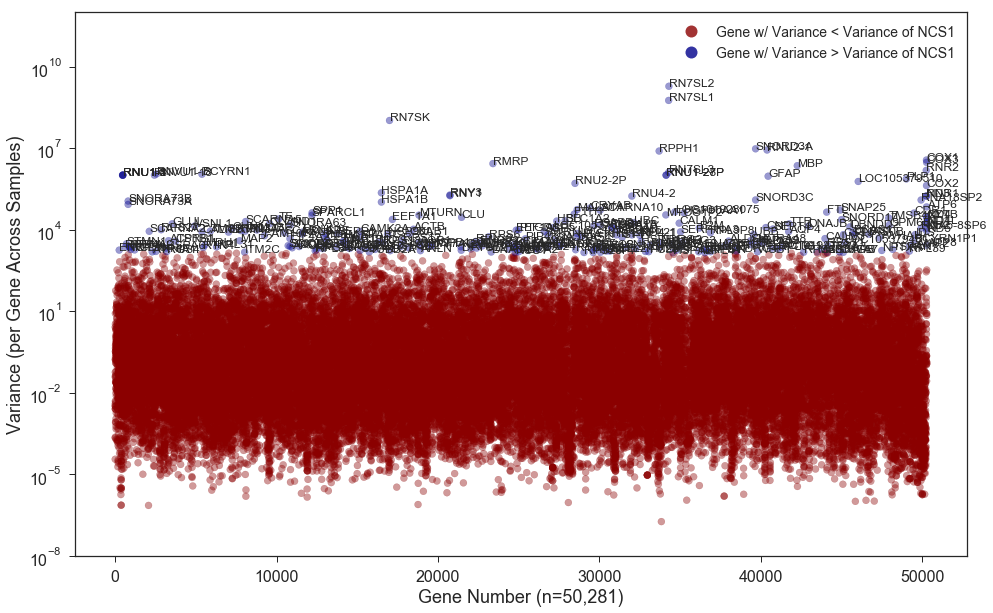

In [46]:
# plot variance
plt.figure(figsize=(16, 10))
plt.yscale("log", basey=10)
plt.ylim(10**-8, 10**12)

plt.xlabel("Gene Number (n=50,281)", fontsize=18)
plt.ylabel("Variance (per Gene Across Samples)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.scatter(x=range(1, tmp.shape[0]+1), y=variance_list, c=colors, alpha=0.4);

marker1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="darkred", alpha=0.8,
                       markersize=12)
marker2 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="darkblue", alpha=0.8,
                       markersize=12)
plt.legend((marker1, marker2), ("Gene w/ Variance < Variance of NCS1", "Gene w/ Variance > Variance of NCS1"),
          prop={'size': 14});

# add name for genes with Variance >= NCS1
for i in range(tmp.shape[0]):
    plt.annotate(names[i], xy=xy[i], textcoords="data");

NCS1 is among the `253 / 50,281 = 0.005` 0.5% most variable genes in this dataset!

In [47]:
# define a function to plot figures
def correlation_plot(data=rna_seq_joined, gene1="NCS1", gene2=False, labelx="NCS1", labely=False, 
                     scaling=(0.7, 0.9)):
    '''
    A helpful function to draw a scatter plot of FPKM expression values for two different genes along with 
    statistics. 'data' should be a pandas DataFrame and 'gene1'/'gene2' columns of this DataFrame ('str').
    '''
    # select genes from input data frame
    _gene1 = data[[gene1]].astype("float").transpose()
    _gene2 = data[[gene2]].astype("float").transpose()
    
    # plot spearman and pearson correlation coefficients for NCS1 vs ITPR1
    pearson = np.corrcoef(_gene1, _gene2)[0, 1] # Pearson's r
    spearman = scipy.stats.spearmanr(a=_gene1, b=_gene2, axis=1) # Spearman's r

    # plot 'FPKM' of gene1 and gene 2
    sns.set(style="ticks")
    grid = sns.FacetGrid(data=data, hue="structure_name", aspect=1.2, size=6, despine=False, legend_out=False) 
    grid.map(plt.scatter, gene1, gene2, s=80, edgecolor="black", alpha=0.9)
    grid.add_legend(fontsize=12, title=False)
    
    # adjust fonts, labels, etc.
    plt.grid(b=True, which="major")
    plt.xlabel("Expression [FPKM] of {} (n=377 patients)".format(labelx), fontsize=16)
    plt.ylabel("Expression [FPKM]  of {} (n=377 patients)".format(labely), fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("Scatter Plot of {} vs {} Expression".format(labelx, labely), fontsize=20)
    
    # add a regression line
    m, b = np.polyfit(_gene1.values.flatten(), _gene2.values.flatten(), deg=1)
    x_values = np.linspace(_gene1.values.min(), _gene1.values.max(), 100)
    plt.plot(x_values, x_values * m + b, "-", color="black", linewidth=5, alpha=0.7)
    
    # add the calculated correlation statistics as text
    plt.text(x=scaling[0]*_gene1.values.max(), y=scaling[1]*_gene2.values.max(), fontsize=15, bbox=dict(
        facecolor='darkred', alpha=0.5), s="Pearson = {r1}\nSpearman = {r2}\nLSR Line of Best Fit".format(
        r1=round(pearson, 3), r2=round(np.float64(str(spearman)[28:38]), 4)));

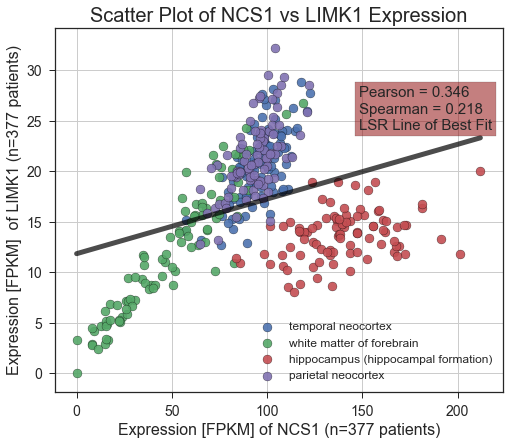

In [48]:
correlation_plot(gene2="LIMK1", labely="LIMK1", scaling=(0.7, 0.75));

In [304]:
def boxplot_of_regions(df=rna_seq_joined, gene_name="NCS1", kind="box", hue=None, order=None):
    '''
    Enter a valid hgnc gene name and plot boxplots of FPKM values across 4 different brain regions.
    '''   
    # set plot style
    sns.set(style="ticks")
    
    # transform data
    df_long = pd.melt(df, "structure_name", var_name="gene", value_name="expression")
    mask = df_long[["gene"]] == gene_name
    df_long = df_long[mask.values]
    df_long[["expression"]] = df_long[["expression"]].astype(float)
    _df = df
    _df["NCS1"] = _df["NCS1"].astype(float)
    
    # create factor plot
    fc = sns.factorplot(x="structure_name", y=gene_name, hue=hue, saturation=0.5, width=0.7, order=order,
                        fliersize=8, linewidth=4, data=_df, kind=kind, size=7, aspect=1.5, legend_out=False);
    fc.despine(top=False, right=False);
    plt.grid(b=True, which="major")
    fc.add_legend(fontsize=12, title=False);
    plt.ylabel("NCS1 Gene Expression [FPKM]", fontsize=16);
    plt.xticks(fontsize=14, rotation=20)
    plt.yticks(fontsize=14)
    plt.xlabel("Brain Regions", fontsize=16);
    plt.title("NCS1 Expression in 4 Different Brain Regions", fontsize=20);

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


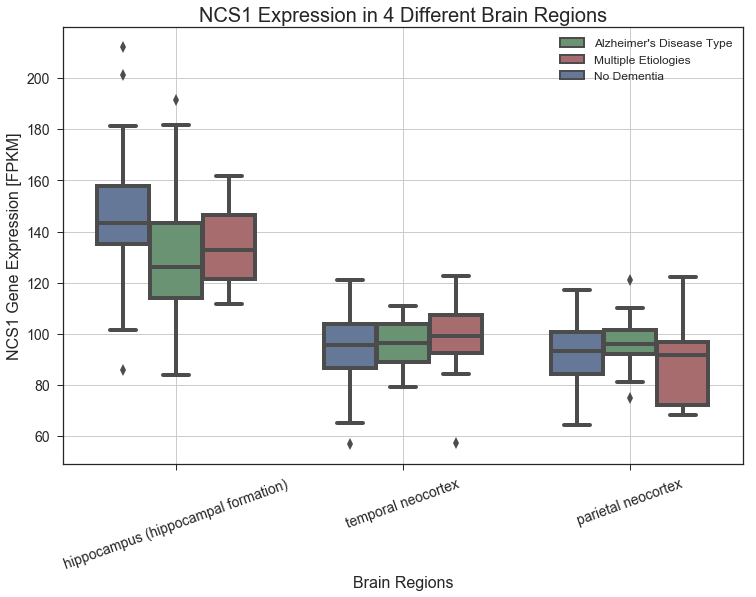

In [305]:
## categorical variables:
# "dsm_iv_clinical_diagnosis"
# "braak"
# "act_demented"
# "ever_tbi_w_loc"
# "apo_e4_allele"
# "race"
# "hispanic"
# "nia_reagan"

# log2 transformation does not make a lot of sense with this data
all_data_joined_log = all_data_joined.copy()
all_data_joined_log[["NCS1"]] = np.log2(all_data_joined_log[["NCS1"]]+1)

# select:
# 'dsm_iv_clinical_diagnosis' = 'Alzheimer's Disease Type' and not 'structure_name' = 'white matter of forebrain'
_dis = set(["Alzheimer's Disease Type", "Multiple Etiologies", "No Dementia"])

_df_selected = all_data_joined[([True if value in _dis else False for value in all_data_joined.dsm_iv_clinical_diagnosis.values]) & (all_data_joined.structure_name != "white matter of forebrain")]

# plot!
boxplot_of_regions(df=_df_selected, gene_name="NCS1", hue="dsm_iv_clinical_diagnosis", kind="box",
                  order=["hippocampus (hippocampal formation)", "temporal neocortex", "parietal neocortex"])
plt.savefig("/Users/daniel/Desktop/NCS1_in_16_brain_regions.pdf", bbox_inches="tight", pad_inches=1)

## High Variance Genes - Heatmap

Genes with variance >= variance of NCS1 are selected an clustered (hierarchical clustering, euclidian distance-based with average linkage). The distribution of FPKM values suggests a log2(FPKM+1) transformation (see below).

In [51]:
# prepare a transformed data frame of all genes for plotting
all_cluster_log2 = np.log2(rna_seq_joined.iloc[:, 0:50281].astype(float)+1)

# select genes and transform
sel_cluster_log2 = np.log2(rna_seq_joined.loc[:, larger_than_NCS1].astype(float)+1)
sel_cluster = rna_seq_joined.loc[:, larger_than_NCS1].astype(float)

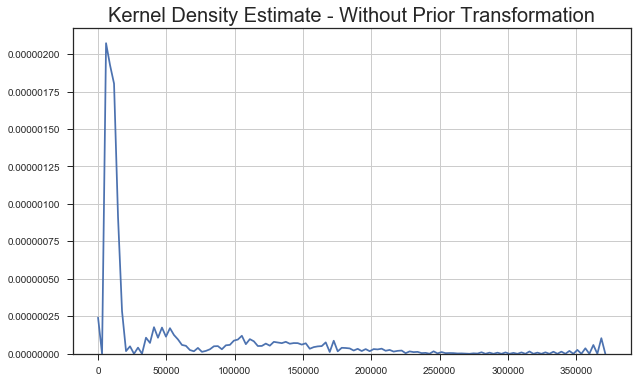

In [52]:
plt.figure(figsize=(10, 6))
sns.set(style="ticks")
plt.grid(b=True, which="major")
sns.distplot(sel_cluster.values.flatten(), hist=False);
plt.title("Kernel Density Estimate - Without Prior Transformation", fontsize=20);

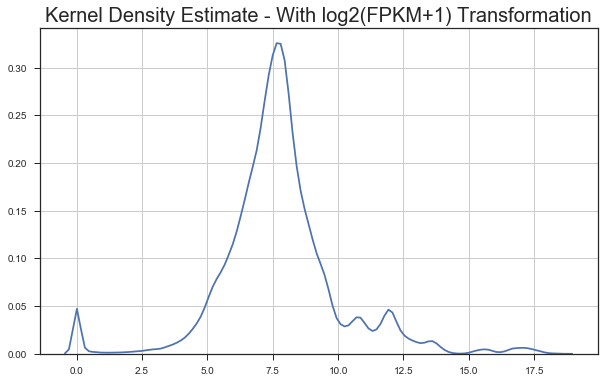

In [53]:
plt.figure(figsize=(10, 6))
sns.set(style="ticks")
plt.grid(b=True, which="major")
sns.distplot(sel_cluster_log2.values.flatten(), hist=False);
plt.title("Kernel Density Estimate - With log2(FPKM+1) Transformation", fontsize=20);

The same seems not to be true for all genes (50,281). Probably because so many genes have very low variance.

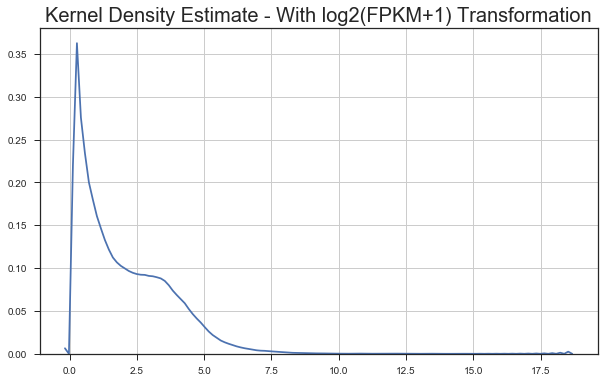

In [54]:
plt.figure(figsize=(10, 6))
sns.set(style="ticks")
plt.grid(b=True, which="major")
sns.distplot(all_cluster_log2.values.flatten(), hist=False);
plt.title("Kernel Density Estimate - With log2(FPKM+1) Transformation", fontsize=20);

temporal neocortex : darkred
white matter of forebrain : darkgreen
hippocampus (hippocampal formation) : darkblue
parietal neocortex : gold


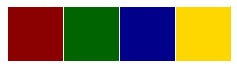

In [55]:
# create a color data frame to map rows to certain colors
sns.set(color_codes=True)
_ = rna_seq_joined.copy()
structure = _.pop("structure_name")

col = dict(zip(structure.unique(), ["darkred", "darkgreen", "darkblue", "gold"]))
row_colors = structure.map(col)

# plot colors
sns.palplot(list(col.values()))

_a, _b = list(col.keys()), list(col.values())
for i in range(4):
    print("{a} : {b}".format(a=_a[i], b=_b[i]))

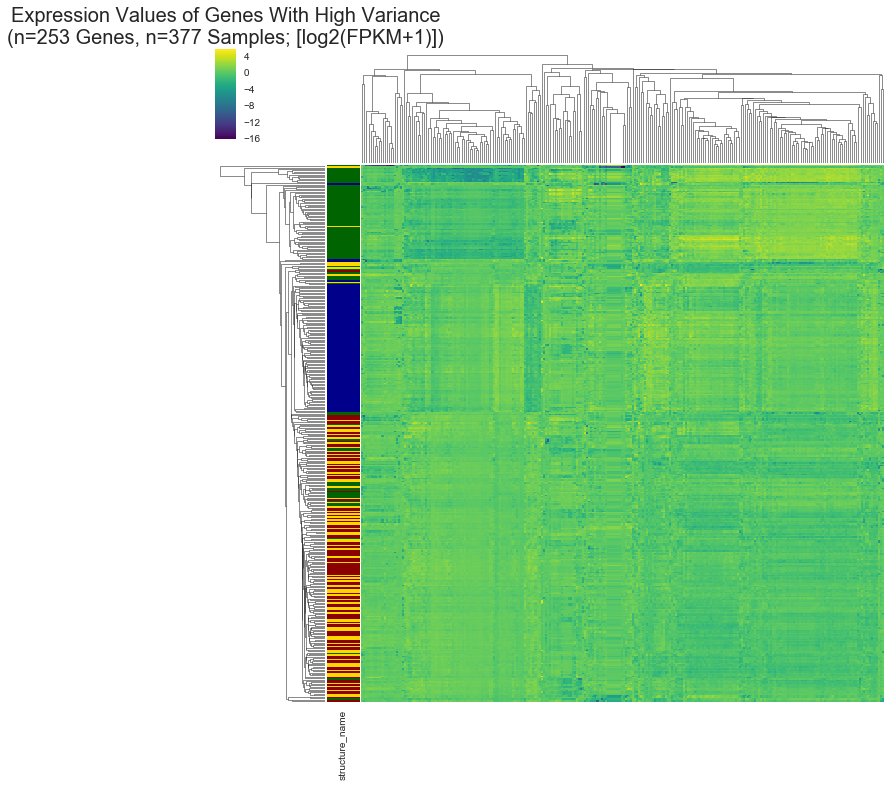

In [56]:
# plot clustered heatmap
hm = sns.clustermap(sel_cluster_log2, cmap="viridis", z_score=1, yticklabels=False, xticklabels=False,
                    figsize=(12, 12), row_colors=row_colors); 
plt.title("Expression Values of Genes With High Variance\n(n=253 Genes, n=377 Samples; [log2(FPKM+1)])", 
          fontsize=20);

Color-coded points could help to tell whether the two distinct "clusters" that drastically reduce the correlation between NCS1vsLIMK1 and NCS1vsITPR1 belong either to certain brain regions or disease states. 

> TODO:
>
> 1. Color-code brain regions - DONE
>
> 2. add regression lines to above figure - DONE
>
> 3. Color_code diseases - DONE

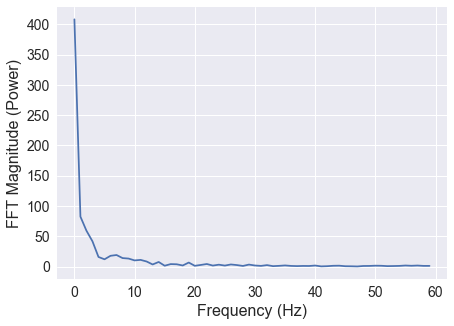

In [57]:
# FFT algorithm - docs: https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.fft.html
# resource: https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

tmp_data = pd.read_table("/Users/daniel/Documents/Yale/Projects/calcium_imaging/results/2018_03_29_19.25.53_normalized_cell_traces.txt",
                        sep=" ", header=None)
trace_no = 3
plt.figure(figsize=(7, 5))
N = tmp_data.iloc[trace_no, 160:280].shape[0]
plt.plot(np.abs(np.fft.rfft(tmp_data.iloc[trace_no, :])[:N//2])); 
plt.xlabel("Frequency (Hz)", fontsize=16);
plt.ylabel("FFT Magnitude (Power)", fontsize=16);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

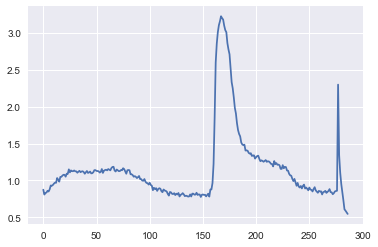

In [58]:
plt.plot(tmp_data.iloc[1, :]);